# Problem Statement

## Create a Model that detects which is fake news and which is real news

### Importing Libraries

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [41]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer, TfidfVectorizer
import nltk
from string import punctuation
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer,WordNetLemmatizer

### Reading File

In [42]:
df = pd.read_csv('news.csv')
df.drop('Unnamed: 0',axis=1,inplace=True) 

In [43]:
df

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [44]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


In [45]:
df.describe()


,title,text,label
count,6335,6335,6335
unique,6256,6060,2
top,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL
freq,5,58,3171


### Data Preprocessing

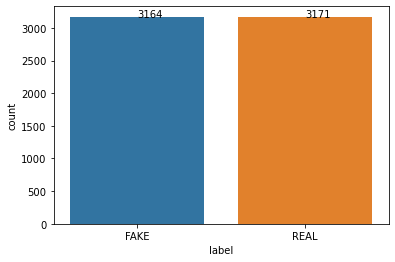

In [46]:
f=sns.countplot(x='label',data=df)
for i in f.patches:
    x=i.get_x() + i.get_width()/2
    y=i.get_y() + i.get_height()
    plt.annotate(i.get_height(),(x,y))
plt.show()

In [47]:
df.groupby('label').describe()


title                                                                 \
      count unique                                                top freq   
label                                                                        
FAKE   3164   3107  Hillary’s “Big Tent” is Obama’s “Grand Bargain...    3   
REAL   3171   3149                      OnPolitics | 's politics blog    5   

       text                                                                 
      count unique                                                top freq  
label                                                                       
FAKE   3164   3071                                                      36  
REAL   3171   2989  Killing Obama administration rules, dismantlin...   58

In [48]:
df['text'] = df['text'].apply(lambda x: ' '.join(x.split()[0:200]))

In [49]:
df['text_length'] = df['text'].str.split().str.len()
df.sample(5)

,title,text,label,text_length
5615,Liberty or State Control? You Decide,Op-Ed by Laraine C. Abbey President Obama’s st...,FAKE,25
4701,McCarthy Bombshell Leaves House GOP in Chaos,House Republicans are in chaos after Thursday'...,REAL,200
1336,Anti-terrorism crackdowns may have spurred att...,The four men — two of them brothers — who turn...,REAL,200
3573,"Dead heat: Trump, Clinton tied in 3 swing-stat...","The election in 232 photos, 43 numbers and 131...",REAL,20
5086,DC Leaks Exposes Soros Plan to ‘Counter Russia...,"By wmw_admin on October 29, 2016 Richard Brand...",FAKE,200


In [50]:
df.groupby('label').describe().T


label                     FAKE         REAL
text_length count  3164.000000  3171.000000
            mean    176.516435   182.799117
            std      51.824731    50.323512
            min       0.000000     7.000000
            25%     200.000000   200.000000
            50%     200.000000   200.000000
            75%     200.000000   200.000000
            max     200.000000   200.000000

In [51]:
df["title_length"] = df['title'].str.split().str.len()
df.sample(5)

,title,text,label,text_length,title_length
3259,Which States Can Gary Johnson and Jill Stein S...,"Like his third-party forefathers, Gary Johnson...",REAL,200,9
4433,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",Email It appears Bill and Hillary Clinton are ...,FAKE,200,12
4009,Ten inconsistencies in Donald Trump's big fore...,For a speech purporting to challenge Washingto...,REAL,200,9
3155,Don’t Believe The Myth That Weightlifting Will...,"Many older physical trainers, and even those y...",FAKE,200,10
5612,Police Depts. Paid AT&T Millions To Scrutinize...,"Edmondo Burr in News , US // 0 Comments Adam S...",FAKE,200,12


In [52]:
df[(df['text_length']==0) & (df['label']=='FAKE')]


,title,text,label,text_length,title_length
106,The Arcturian Group by Marilyn Raffaele Octobe...,,FAKE,0,10
710,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,,FAKE,0,10
806,Southern Poverty Law Center Targets Anti-Jihad...,,FAKE,0,10
919,Refugee Resettlement Watch: Swept Away In Nort...,,FAKE,0,8
940,Michael Bloomberg Names Technological Unemploy...,,FAKE,0,11
1664,Alert News : Putins Army Is Coming For World W...,,FAKE,0,16
1736,An LDS Reader Takes A Look At Trump Accuser Je...,,FAKE,0,17
1851,America’s Senator Jeff Sessions Warns of Worse...,,FAKE,0,10
1883,Paris Migrant Campers Increase after Calais Is...,,FAKE,0,8
1941,Putins Army is coming for World war 3 against ...,,FAKE,0,15


In [53]:
df = df[df['text_length']!=0]


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6299 entries, 0 to 6334
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         6299 non-null   object
 1   text          6299 non-null   object
 2   label         6299 non-null   object
 3   text_length   6299 non-null   int64 
 4   title_length  6299 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 295.3+ KB


In [55]:
df.groupby('label').describe().T


label                      FAKE         REAL
text_length  count  3128.000000  3171.000000
             mean    178.547954   182.799117
             std      48.516841    50.323512
             min       1.000000     7.000000
             25%     200.000000   200.000000
             50%     200.000000   200.000000
             75%     200.000000   200.000000
             max     200.000000   200.000000
title_length count  3128.000000  3171.000000
             mean     11.137468     9.861243
             std       4.559064     3.199711
             min       1.000000     2.000000
             25%       8.000000     8.000000
             50%      11.000000    10.000000
             75%      13.000000    12.000000
             max      53.000000    27.000000

In [56]:
df.shape


(6299, 5)

In [57]:
lemma = WordNetLemmatizer()
stemmer = PorterStemmer()

In [58]:
stopwards = ['’','”','“','–','—']

### NLP Steps

In [59]:
def text_process(t):
    all_words=[]
    for sent in nltk.sent_tokenize(t.lower()):
        words=nltk.word_tokenize(sent)
        words=[word for word  in words if (word not in stopwords.words('english'))]
        #words=[lemma.lemmatize(word,wordnet.ADJ) for word in words]
        words=[stemmer.stem(word) for word in words]
        words=[word for word  in words if word not in punctuation]
        words = [word for word in words if not word.isnumeric()]
        all_words+=words
    all_words=''.join([ch for ch in ' '.join(all_words) if (ch not in punctuation) and (not ch.isnumeric() and (ch not in stopwards))])
    
    return all_words

In [60]:
df['text']


0       Daniel Greenfield, a Shillman Journalism Fello...
1       Google Pinterest Digg Linkedin Reddit Stumbleu...
2       U.S. Secretary of State John F. Kerry said Mon...
3       — Kaydee King (@KaydeeKing) November 9, 2016 T...
4       It's primary day in New York and front-runners...
                              ...                        
6330    The State Department told the Republican Natio...
6331    The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332    Anti-Trump Protesters Are Tools of the Oligarc...
6333    ADDIS ABABA, Ethiopia —President Obama convene...
6334    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Name: text, Length: 6299, dtype: object

In [61]:
df['text'].head(10).apply(text_process)


0    daniel greenfield shillman journal fellow free...
1    googl pinterest digg linkedin reddit stumbleup...
2    us secretari state john f kerri said monday st...
3     kayde king kaydeek novemb lesson tonight s de...
4    s primari day new york frontrunn hillari clint...
5     immigr grandpar year ago arriv new york citi ...
6    share bayle luciani left screenshot bayle caug...
7    czech stockbrok save jewish children nazi germ...
8    hillari clinton donald trump made inaccur clai...
9    iranian negoti reportedli made lastditch push ...
Name: text, dtype: object

In [62]:
df['text_length'].max()


200

In [63]:
df["text"]=df["text"].apply(text_process)


In [65]:
tfidfV = TfidfVectorizer()
tf_idf = tfidfV.fit_transform(df['text'])

In [66]:
tf_df = pd.DataFrame(tf_idf.toarray(),columns=tfidfV.get_feature_names())
tf_df.head()

,aa,aaa,aaadd,aab,aadmi,aaliya,aam,aamaq,aap,aarhu,...,ťđ,ελληνικά,νοεμβρίου,главная,октября,русский,эa,эin,القادمون,عربي
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
tf_df.shape


(6299, 29249)

In [68]:
tfidfV.get_feature_names()


['aa',
 'aaa',
 'aaadd',
 'aab',
 'aadmi',
 'aaliya',
 'aam',
 'aamaq',
 'aap',
 'aarhu',
 'aaron',
 'aaronapollocamp',
 'aarondmiller',
 'aarp',
 'aasetlayout',
 'ab',
 'abaaoud',
 'ababa',
 'aback',
 'abadi',
 'abandon',
 'abat',
 'abba',
 'abbar',
 'abbey',
 'abbeyinspir',
 'abbi',
 'abbott',
 'abbottabad',
 'abc',
 'abcnewsgocom',
 'abcpolit',
 'abcwashington',
 'abd',
 'abdel',
 'abdelhamid',
 'abdelmoumen',
 'abdeslam',
 'abdic',
 'abdikadir',
 'abdkir',
 'abdollahi',
 'abdomen',
 'abdomin',
 'abdrabbu',
 'abduct',
 'abductor',
 'abdul',
 'abdulazeez',
 'abdulaziz',
 'abdulla',
 'abdullah',
 'abdulzai',
 'abdur',
 'abe',
 'abedin',
 'abedini',
 'abedinwein',
 'abel',
 'abeldangernet',
 'aberfan',
 'abernathi',
 'aberr',
 'aberrationssudden',
 'abet',
 'abhor',
 'abhorr',
 'abiali',
 'abid',
 'abigail',
 'abil',
 'abitt',
 'abject',
 'abjectli',
 'abl',
 'ablaz',
 'abli',
 'abnorm',
 'abnoush',
 'aboard',
 'abolish',
 'abolit',
 'abomin',
 'abomination',
 'abood',
 'aborigin',
 'a

In [69]:
from sklearn.model_selection import train_test_split


In [71]:
xtrain,xtest,ytrain,ytest = train_test_split(tf_df,df['label'],test_size=0.25,random_state=101)


In [72]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

In [74]:
model_bnb = BernoulliNB().fit(xtrain,ytrain)
print(model_bnb.score(xtrain,ytrain))
print(model_bnb.score(xtest,ytest))

0.9451735817104149
0.8838095238095238


In [75]:
model_mnb = MultinomialNB().fit(xtrain,ytrain)
print(model_mnb.score(xtrain,ytrain))
print(model_mnb.score(xtest,ytest))

0.930567315834039
0.8622222222222222


In [76]:
#Deployment

In [77]:
xtrain1,xtest1,ytrain1,ytest1 = train_test_split(df['text'],df['label'],test_size=0.25, random_state=11)

In [78]:
from sklearn.pipeline import Pipeline


In [79]:
aaa= map(text_process,df['text'])


In [81]:
TfidfVectorizer().fit_transform(aaa)


<6299x28449 sparse matrix of type '<class 'numpy.float64'>'
	with 500094 stored elements in Compressed Sparse Row format>

In [82]:
model_pipe = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('clf',BernoulliNB())
])

In [83]:
model_pipe.fit(xtrain1,ytrain1)


Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001718EB60EE0>)),
                ('tfidf', TfidfTransformer()), ('clf', BernoulliNB())])

In [84]:
model_pipe.score(xtrain1,ytrain1)
model_pipe.score(xtest1,ytest1)


0.6387301587301587

In [85]:
ypred = model_pipe.predict(xtest1)


In [86]:
print(classification_report(ytest1,ypred))
print(confusion_matrix(ytest1,ypred))

              precision    recall  f1-score   support

        FAKE       0.82      0.33      0.47       766
        REAL       0.59      0.93      0.73       809

    accuracy                           0.64      1575
   macro avg       0.71      0.63      0.60      1575
weighted avg       0.70      0.64      0.60      1575

[[252 514]
 [ 55 754]]


In [87]:
from sklearn.metrics import accuracy_score
pred = model_bnb.predict(xtest)
score = accuracy_score(ytest, pred)
print("Accuracy of the model: {}%".format(score*100))

Accuracy of the model: 88.38095238095238%
